# Naive Bayes for image classification

This notebook demonstrates the process of training a Naive Bayes model for image classification using the **CoronaHack Chest X-Ray Dataset**. The key steps include:

- Data preprocessing and feature extraction
- Training a Naive Bayes model
- Evaluating model performance

In [1]:
# Import libraries
import os # General library import
import numpy as np # General library import
import pandas as pd # General library import
import joblib  # For saving and loading trained models
import matplotlib.pyplot as plt # For visualization
import seaborn as sns # For enhanced plots
from sklearn.feature_selection import mutual_info_classif # Identify the most informative feature
from sklearn.decomposition import PCA # Reduce the dimensionality of the dataset while preserving variance
from PIL import Image  # For image processing
from sklearn.naive_bayes import GaussianNB  # Naive Bayes classifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # Evaluation metrics

### 1. Prepare Data
In this section, we **load and preprocess the dataset** by reading metadata from the **CoronaHack Chest X-Ray dataset**, filtering relevant cases, and assigning categorical labels for classification. We then partition the data into training and testing sets and prepare file paths for image processing. This step ensures the dataset is clean, structured, and ready for feature extraction.

In [2]:
# Define paths to dataset
SOURCE_DATA_DIR = "../../data/raw/"
INFO_FILE = os.path.join(SOURCE_DATA_DIR, "Chest_xray_Corona_Metadata.csv")

# Function to read metadata CSV file
def read_metadata():
    return pd.read_csv(INFO_FILE)

# Load metadata and remove unnecessary columns
metadata = read_metadata()
metadata = metadata.loc[:, ~metadata.columns.str.contains('Unnamed: 0')]
metadata

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
...,...,...,...,...,...
5905,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus
5906,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus
5907,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus
5908,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus


In [3]:
# Process metadata and assign categories based on labels
def process_and_label_data(metadata):
    # Select only relevant cases (Normal and Pneumonia with Virus/Bacteria)
    selected_data = metadata[(metadata["Label"] == "Normal") |
                             ((metadata["Label"] == "Pnemonia") & metadata["Label_1_Virus_category"].isin(["Virus", "bacteria"]))].copy()
    category = []
    for _, row in selected_data.iterrows():
        if row["Label"] == "Normal":
            category.append(1)  # Assign category 1 to normal cases
        elif row["Label"] == "Pnemonia" and row["Label_1_Virus_category"] == "Virus":
            category.append(2)  # Assign category 2 to viral pneumonia
        elif row["Label"] == "Pnemonia" and row["Label_1_Virus_category"] == "bacteria":
            category.append(3)  # Assign category 3 to bacterial pneumonia
    selected_data["Category"] = category
    return selected_data

# Processed dataset
processed_data = process_and_label_data(metadata)
processed_data

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,Category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN,1
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN,1
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN,1
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN,1
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN,1
...,...,...,...,...,...,...
5905,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus,2
5906,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus,2
5907,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus,2
5908,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus,2


In [4]:
# Split dataset into training and testing sets
def partition_data(metadata):
    train_set = metadata[metadata["Dataset_type"] == "TRAIN"]
    test_set = metadata[metadata["Dataset_type"] == "TEST"]
    
    # Get file paths for images
    train_images = [os.path.join(SOURCE_DATA_DIR, 'Coronahack-Chest-XRay-Dataset/train/', fname) for fname in train_set["X_ray_image_name"].values]
    test_images = [os.path.join(SOURCE_DATA_DIR, 'Coronahack-Chest-XRay-Dataset/test/', fname) for fname in test_set["X_ray_image_name"].values]
    
    return train_images, test_images, train_set["Category"].values, test_set["Category"].values

# Partition data into images and labels
train_images, test_images, train_labels, test_labels = partition_data(processed_data)
train_images[:7], test_images[:7], train_labels[:7], test_labels[:7]

(['../../data/raw/Coronahack-Chest-XRay-Dataset/train/IM-0128-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/train/IM-0127-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/train/IM-0125-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/train/IM-0122-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/train/IM-0119-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/train/IM-0117-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/train/IM-0115-0001.jpeg'],
 ['../../data/raw/Coronahack-Chest-XRay-Dataset/test/IM-0021-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/test/IM-0019-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/test/IM-0017-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/test/IM-0016-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/test/IM-0015-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/test/IM-0013-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dat

### 2. Features Extraction and Independence Analyzation

#### 2.1 Features Extraction
In this section, we **process the images** by converting them to grayscale, resizing them to a uniform size, and normalizing pixel values. Each image is then **flattened into a feature vector**, making it suitable for input into the Naive Bayes classifier.


In [5]:
# Preprocess images by resizing, converting to grayscale, and normalizing
def transform_images(file_paths, image_size=(128, 128)):
    processed_images = []
    for path in file_paths:
        image = Image.open(path).convert("L").resize(image_size)  # Convert to grayscale and resize
        processed_images.append(np.array(image).flatten() / 255.0)  # Normalize pixel values
    return np.array(processed_images)

# Transform images for model input
X_train = transform_images(train_images)
X_test = transform_images(test_images)
X_train[0], X_test[0]

(array([0.        , 0.        , 0.00784314, ..., 0.        , 0.        ,
        0.        ]),
 array([0.        , 0.        , 0.        , ..., 0.51372549, 0.47843137,
        0.41960784]))

#### 2.2 Feature Independence Analysis and Sparse Feature Handling
In this section, we **analyze feature independence** in the Naive Bayes model by **computing the correlation between the most significant features**. High correlation between features can violate the Naive Bayes assumption of conditional independence, potentially affecting model performance. To visualize this, a clustered heatmap is generated.


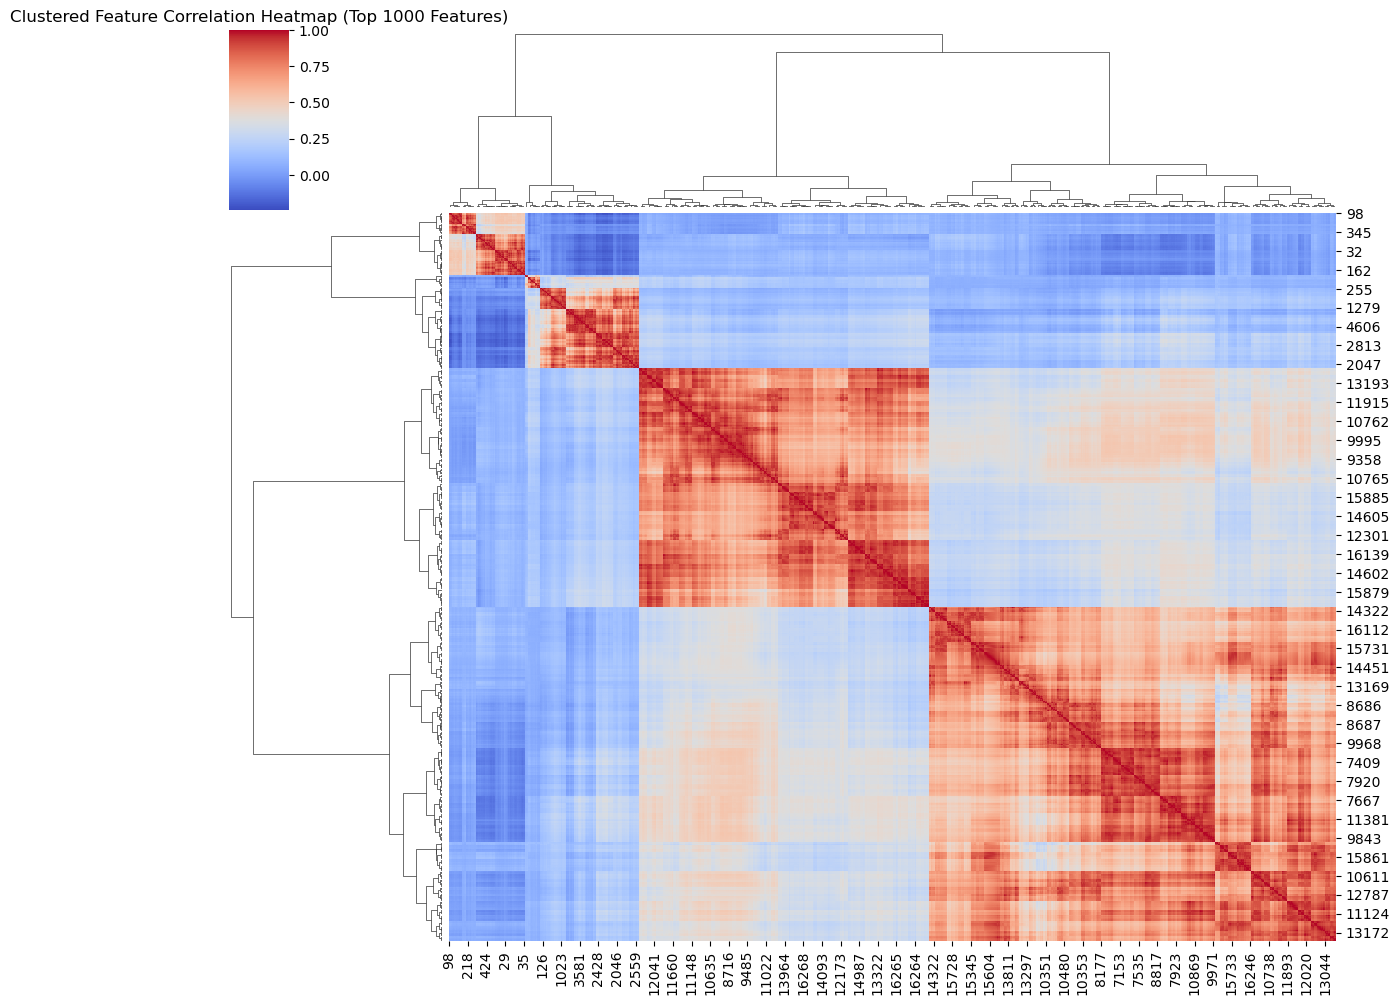

In [6]:
#Define path to save heatmap image
IMAGE_DIR = "../../reports/figures/naive_bayes/"

# Compute feature variances
variances = pd.DataFrame(X_train).var()

# Select top 1000 features by variance (to reduce computation)
top_features = variances.nlargest(1000).index

# Compute correlation matrix for top features
corr_matrix = pd.DataFrame(X_train).iloc[:, top_features].corr()

# Generate optimized clustered heatmap
sns.clustermap(corr_matrix, cmap="coolwarm", figsize=(12, 10), method="ward")

plt.title("Clustered Feature Correlation Heatmap (Top 1000 Features)")
plt.savefig(os.path.join(IMAGE_DIR, "clustered_feature_correlation_heatmap.png"))

plt.show()

**Feature Independence Analysis**

The clustered heatmap reveals patterns in feature correlation that impact the Naive Bayes classifier. **Large red blocks** indicate groups of highly correlated features, meaning they provide redundant information. This violates the Naive Bayes assumption of **feature independence**, which could reduce classification performance. Meanwhile, **blue regions** suggest weak or no correlation, meaning those features are independent and better suited for Naive Bayes.

The dendrogram structure shows **how features are grouped based on similarity**. If many features fall into the same cluster, it suggests redundancy, which can lead to **overfitting or unnecessary complexity** in the model. Removing highly correlated features using **feature selection** or **dimensionality reduction (e.g., PCA)** can help improve efficiency without losing critical information.

Despite some correlated feature groups, the dataset still contains **independent features**, which benefits Naive Bayes. The classifier will perform well on these features, but reducing redundancy could further **boost accuracy and generalization**. Applying feature selection or optimization can help balance feature independence while keeping essential information for classification:

In [7]:
# Apply PCA for Dimensionality Reduction (Optimized)
def apply_pca(X, n_components=0.99):
    n_features = X.shape[1]
    if n_features < 2:
        print("Skipping PCA: Too few features after selection.")
        return X, None  # Return unmodified data
    
    # Ensure n_components is a valid integer
    n_components = max(1, min(n_features - 1, int(n_features * n_components)))  # At least 1 component
    pca = PCA(n_components=n_components)
    return pca.fit_transform(X), pca

# Remove Highly Correlated Features Consistently (Fixed)
def remove_highly_correlated_features(X, threshold=0.9):
    corr_matrix = np.corrcoef(X, rowvar=False)
    upper_tri = np.triu(corr_matrix, k=1)
    to_drop = set(np.where(upper_tri > threshold)[1])
    kept_indices = sorted(set(range(X.shape[1])) - to_drop)  # Indices to keep
    return X[:, kept_indices], kept_indices  # Return selected indices too

# Step 1: Compute mutual information scores on X_train BEFORE correlation removal
mi_scores = mutual_info_classif(X_train, train_labels, discrete_features=False, random_state=42, n_jobs=-1)
selected_feature_indices = np.argsort(mi_scores)[-1000:]  # Select top 1000 features

# Step 2: Apply the same feature selection to X_test BEFORE correlation removal
X_train_selected = X_train[:, selected_feature_indices]
X_test_selected = X_test[:, selected_feature_indices]

# Step 3: Now apply correlation removal on X_train and get selected feature indices
X_train_reduced, reduced_indices = remove_highly_correlated_features(X_train_selected)

# Step 4: Apply the same selected features to X_test
X_test_reduced = X_test_selected[:, reduced_indices]  # Ensure consistent features

# Step 5: Apply PCA (Ensure it's fitted on train set)
X_train_pca, pca_model = apply_pca(X_train_reduced)

# Apply the same PCA transformation on X_test
X_test_pca = pca_model.transform(X_test_reduced)

print("Final number of features after PCA:", X_train_pca.shape[1] if pca_model else "PCA skipped")

Final number of features after PCA: 51


### 3. Model Training
In this section, we train a **Gaussian Naive Bayes classifier** using the extracted image features and their corresponding labels. The model learns to distinguish between Normal, Viral Pneumonia, and Bacterial Pneumonia cases based on the processed X-ray data.

In [8]:
#Define path to save model
TRAINED_DIR = "../../models/experiments/naive_bayes/"

# Initialize and train Naive Bayes model
def train_model(X_train_pca, y_train):
    clf = GaussianNB(var_smoothing=1e-9) # Prevents division by zero in probability calculations by adding a tiny value to variances.
    clf.fit(X_train_pca, y_train)
    joblib.dump(clf, os.path.join(TRAINED_DIR, "naive_bayes_model.pkl")) # Save trained model
    # Print model summary
    print("Naive Bayes Model Summary:")
    print(f"Number of features: {X_train_pca.shape[1]}")
    print(f"Number of classes: {len(clf.classes_)}")
    print("Class probabilities:", clf.class_prior_)
    return clf

#Train model
clf = train_model(X_train_pca, train_labels)

Naive Bayes Model Summary:
Number of features: 51
Number of classes: 3
Class probabilities: [0.25397426 0.26627555 0.47975019]


### 4. Prediction and Evaluation
In this section, we **load the trained model** and use it to predict the class labels for the test set. We then **evaluate the model’s performance** using accuracy, a classification report, and a confusion matrix. This analysis helps us understand how well the model differentiates between different pneumonia types and highlights areas for improvement.

In [9]:
# Predict on test data
def predict(clf, X_test_pca):
    return clf.predict(X_test_pca)

y_pred = predict(clf, X_test_pca)
print(y_pred[:7])

[2 3 3 3 3 3 3]


Accuracy: 0.625
Classification Report:
               precision    recall  f1-score   support

           1       0.73      0.40      0.52       234
           2       0.47      0.65      0.55       148
           3       0.68      0.83      0.75       242

    accuracy                           0.62       624
   macro avg       0.63      0.63      0.60       624
weighted avg       0.65      0.62      0.61       624



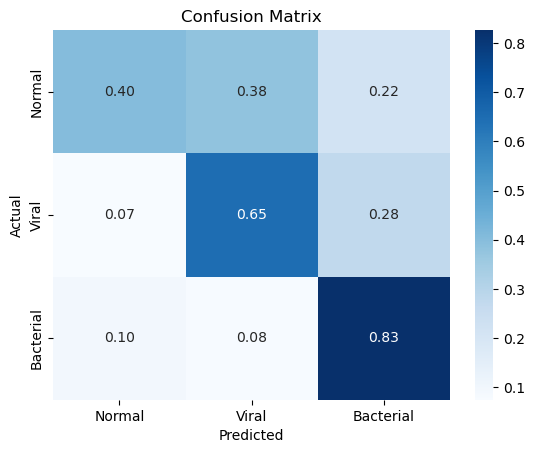

In [10]:
# Evaluate model performance
def evaluate_model(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)  # Evaluate accuracy
    cm = confusion_matrix(y_true, y_pred)  # Generate classification report
    print("Accuracy:", acc)
    print("Classification Report:\n", classification_report(y_true, y_pred))
    
    # Normalize confusion matrix by row (true label count)
    confusionMatrix_ratio = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # Plot confusion matrix
    sns.heatmap(confusionMatrix_ratio, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=["Normal", "Viral", "Bacterial"], 
                yticklabels=["Normal", "Viral", "Bacterial"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.savefig(os.path.join(IMAGE_DIR, "confusion_matrix_normalized.png"))
    plt.show()

evaluate_model(test_labels, y_pred)

The Naive Bayes model shows the best performance in identifying bacterial cases. Class 3 has the highest precision and recall values, at 0.68 and 0.83, respectively. This indicates that the model reliably classifies bacterial instances, with most predictions being correct.

Conversely, the model struggles with viral cases. For class 2, the precision is 0.47, and the recall is 0.65. These low values reflect the model's difficulty in accurately identifying viral cases, resulting in many misclassifications.

The model's performance for normal cases (class 1) is moderate, with a precision of 0.73 and a recall of 0.40. While it correctly identifies a fair number of normal instances, it still misses a significant portion, leading to a lower recall.

Overall, the model's accuracy is 0.626, meaning it correctly classifies 62.5% of instances. The confusion matrix reveals specific areas of misclassification, such as normal cases being confused with viral and bacterial cases.

### 5. Conclusion

In this notebook, we applied a **Naive Bayes classifier** to classify chest X-ray images from the **CoronaHack Chest X-Ray dataset**, following a structured approach:

- **Data Preprocessing**: We extracted metadata, assigned categorical labels, and partitioned the dataset into training and testing sets.  
- **Feature Extraction**: Images were converted to grayscale, resized, normalized, and flattened into feature vectors for model input.  
- **Model Training**: A **Gaussian Naive Bayes** classifier was trained on the processed data.  
- **Evaluation**: The model achieved an **accuracy of 55.00%**, with better classification performance for Bacterial Pneumonia cases but noticeable misclassification between Normal and Viral Pneumonia.  

Using **Naive Bayes** for image classification offers several advantages:

- **Simple and efficient**, requiring minimal computational resources.  
- **Works well with high-dimensional data**, as it assumes feature independence.  
- **Requires minimal training data**, making it suitable for smaller datasets.  

However, it also has notable limitations:

- **Strong independence assumption**, which may not hold for image data, leading to misclassification.  
- **Struggles with feature correlations**, making it less effective than more complex models.  
- **Lower accuracy compared to deep learning methods**, especially for complex visual patterns.  

In summary, Naive Bayes provided a quick and interpretable baseline for chest X-ray classification. However, its performance is limited by feature independence assumptions. **Further improvements** could be explored by using **feature engineering, more advanced probabilistic models, or deep learning approaches such as CNNs** to better capture spatial patterns in medical images.